In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split

import gensim
from gensim import corpora, downloader
from gensim.utils import simple_preprocess

import tensorflow as tf
from tensorflow import keras
from keras.utils import pad_sequences
from tensorflow.keras.applications.xception import Xception,preprocess_input 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception,preprocess_input 
from joblib import dump, load

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import seaborn as sns

2023-06-13 05:43:47.720384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
all_data = pd.read_csv("../data/X_train_update.csv", index_col='Unnamed: 0')
target = pd.read_csv("../data/Y_train_CVw08PX.csv", index_col='Unnamed: 0')

In [3]:
all_data.head()

,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


## Création d'un jeu de donnée "prêt à l'emploi pour les prédictions"

In [4]:
# Détail des labels
labels = sorted(target['prdtypecode'].unique())

In [5]:
# Correpondance label -> index
label2idx = {label : index for index,label in enumerate(labels)}

# Correpondance index -> label
idx2label = {index : label for index,label in enumerate(labels)}

In [6]:
target['index'] = target['prdtypecode'].apply(lambda x : label2idx[x])

In [7]:
target.head()

,prdtypecode,index
0,10,0
1,2280,18
2,50,2
3,1280,7
4,2705,25


In [8]:
all_data['path'] = pd.Series(["image_"+str(i)+"_product_"+str(p)+".jpg" for i,p in zip(all_data['imageid'],all_data['productid'])])

In [9]:
all_data.head()

,designation,description,productid,imageid,path
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,image_1077757786_product_278535884.jpg


In [10]:
X = all_data[['designation', 'path']]

In [11]:
X.head()

,designation,path
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,image_1077757786_product_278535884.jpg


In [12]:
# tokenisation
tokens = [simple_preprocess(sent, min_len = 3) for sent in X['designation']]

In [13]:
# calcul de la longueur max des séquences de tokens
size_tokens = map(lambda x:len(x),tokens)
max_len = max(size_tokens)

print("taille maximum des sequences de tokens :", max_len )

taille maximum des sequences de tokens : 33


In [14]:
# création du dicitonnaire
dictionary = corpora.Dictionary(tokens)

print("nombre de phrases traitées :", dictionary.num_docs)
print("nombre de mots traités :", dictionary.num_pos)

nombre de phrases traitées : 84916
nombre de mots traités : 696547


In [15]:
# tri du dictionnaire par ordre de fréquence d'appartion décroissante des tokens
sort_dictionary = sorted(dictionary.cfs.items(), key = lambda t : -t[1])
words = [dictionary[t[0]] for t in sort_dictionary]

In [16]:
# transformation des tokens de chaque ligne en son identifiant unique dans le dicitonnaire
tokens2id = [dictionary.doc2idx(t) for t in tokens]

# Ajout d'une colone 'tokens' des 33 tokens 
X['tokens'] = pd.Series(list(pad_sequences(tokens2id , maxlen =  max_len, padding = 'post')))

/var/folders/v8/8_sw3bsx1y36811fgs14k_7h0000gn/T/ipykernel_794/2300833434.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tokens'] = pd.Series(list(pad_sequences(tokens2id , maxlen =  max_len, padding = 'post')))


In [17]:
X = pd.concat([X,target['index']], axis = 1)

In [18]:
X.head()

,designation,path,tokens,index
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,image_1263597046_product_3804725264.jpg,"[3, 2, 6, 4, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,image_1008141237_product_436067568.jpg,"[19, 14, 9, 8, 28, 20, 25, 8, 10, 21, 18, 12, ...",18
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,image_938777978_product_201115110.jpg,"[33, 38, 31, 30, 32, 34, 39, 36, 35, 37, 0, 0,...",2
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,image_457047496_product_50418756.jpg,"[45, 42, 43, 40, 44, 41, 0, 0, 0, 0, 0, 0, 0, ...",7
4,La Guerre Des Tuques,image_1077757786_product_278535884.jpg,"[46, 14, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",25


In [19]:
X['str_index'] = X['index'].astype('str')

## Création d'un jeu de test en respectant la distribution dans les classes

In [20]:
# Prédiciotn de 5 % de la taille du jeu de données initial 
#_, X_pred, _, y_pred = train_test_split(X , target , test_size=0.05, random_state = 42, stratify = target['index']) 
_, X_pred, _, y_pred = train_test_split(X , target , test_size=0.05, random_state = 42) 

In [21]:
len(X_pred)

4246

## Prédictions pour le texte

In [50]:
# chargement du modèle
model_text = load( "../models/model_texte_embedding_100.joblib")

In [51]:
X_text = np.asarray([np.asarray(x) for x in X_pred['tokens']])

In [52]:
X_text.shape

(4246, 33)

In [53]:
y_text_proba = model_text.predict(X_text)

133/133 [==============================] - 0s 1ms/step


In [54]:
y_text_pred = np.argmax(y_text_proba , axis =-1)

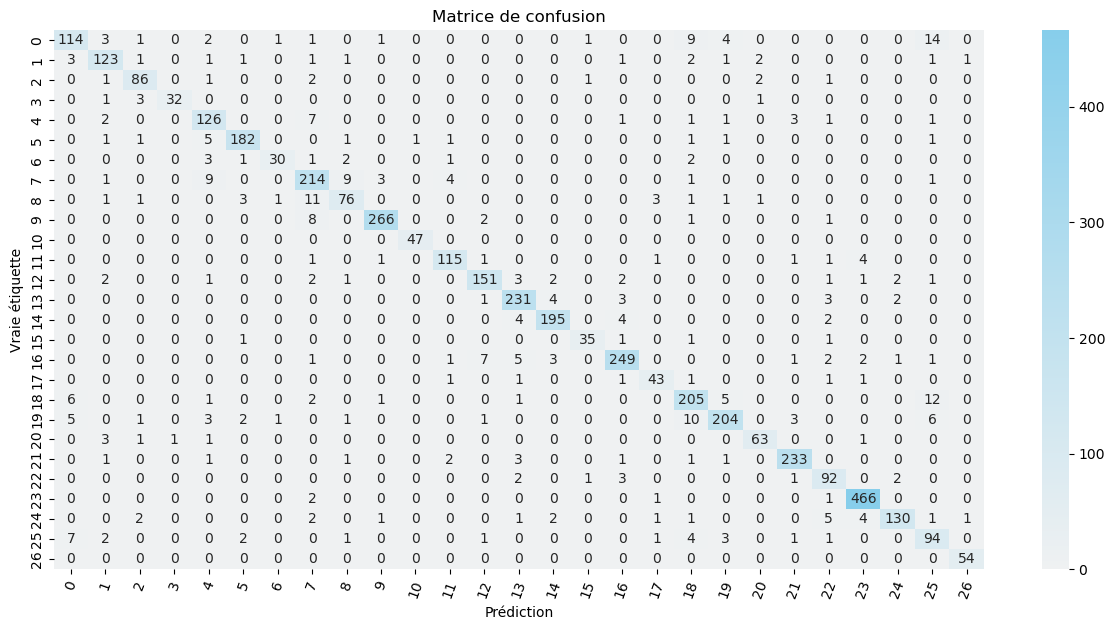

In [55]:
text_cf = confusion_matrix(y_pred['index'], y_text_pred)
plt.figure(figsize=(15, 7))
palette_bleu=sns.light_palette("#87CEEB", as_cmap=True)
sns.heatmap(text_cf, annot=True,  cmap=palette_bleu, fmt = 'd')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.xticks(rotation=70)
plt.ylabel('Vraie étiquette')
plt.show()

In [57]:
print(classification_report(y_pred['index'], y_text_pred))

              precision    recall  f1-score   support

           0       0.84      0.75      0.80       151
           1       0.87      0.88      0.88       139
           2       0.89      0.91      0.90        94
           3       0.97      0.86      0.91        37
           4       0.82      0.88      0.85       143
           5       0.95      0.93      0.94       195
           6       0.91      0.75      0.82        40
           7       0.84      0.88      0.86       242
           8       0.82      0.77      0.79        99
           9       0.97      0.96      0.97       278
          10       0.98      1.00      0.99        47
          11       0.92      0.92      0.92       125
          12       0.92      0.89      0.91       169
          13       0.92      0.95      0.93       244
          14       0.95      0.95      0.95       205
          15       0.92      0.90      0.91        39
          16       0.94      0.91      0.92       273
          17       0.86    

## Prédictions pour les images

In [58]:
image_size = 299 # Modèle Xception
batch_size = 32
prefetch_factor = tf.data.experimental.AUTOTUNE 
path =  "../data/images/image_train/"

In [59]:
# fonction pour le chargement des images sans augmentation
def load_image(filepath) :
    # Chargement de l'image du df en mémoire
    im = tf.io.read_file(filepath)
    
    # Décodage de l'info dans un tenseur RGB
    im = tf.image.decode_jpeg(im, 3)
    
    # Retourne l'image à la bonne dimension 
    im = tf.image.resize(im, size=(image_size, image_size))
    
    # Preprocess du modèle
    im = tf.keras.applications.xception.preprocess_input(im)
        
    return im

In [60]:
X_pred_path = [path + X_pred['path'].iloc[k] for k in range(len(X_pred))]

# définition du dataset
dataset_im_pred = tf.data.Dataset.from_tensor_slices((X_pred_path, y_pred['index']))

# application de la fonction load_image au dataset
dataset_im_pred = dataset_im_pred.map(lambda y, z : [load_image(y),z], num_parallel_calls = -1).cache()

# regroupement en batchs
dataset_im_pred = dataset_im_pred.batch(batch_size).prefetch(prefetch_factor)

In [61]:
# chargement du best modèle texte+image
model_ima = load("../models/xception_unfreeze105_4ep_dataset_full_data.joblib")

In [62]:
score = model_ima.evaluate(dataset_im_pred)

print("Accuracy - Modèle Xception Unfreeze 105 :",score[1])

133/133 [==============================] - 532s 4s/step - loss: 0.9155 - accuracy: 0.7339
Accuracy - Modèle Xception Unfreeze 105 : 0.7338671684265137


In [63]:
y_ima_proba = model_ima.predict(dataset_im_pred, verbose = 1)

133/133 [==============================] - 527s 4s/step


In [64]:
y_ima_pred = np.argmax(y_ima_proba  , axis =-1)

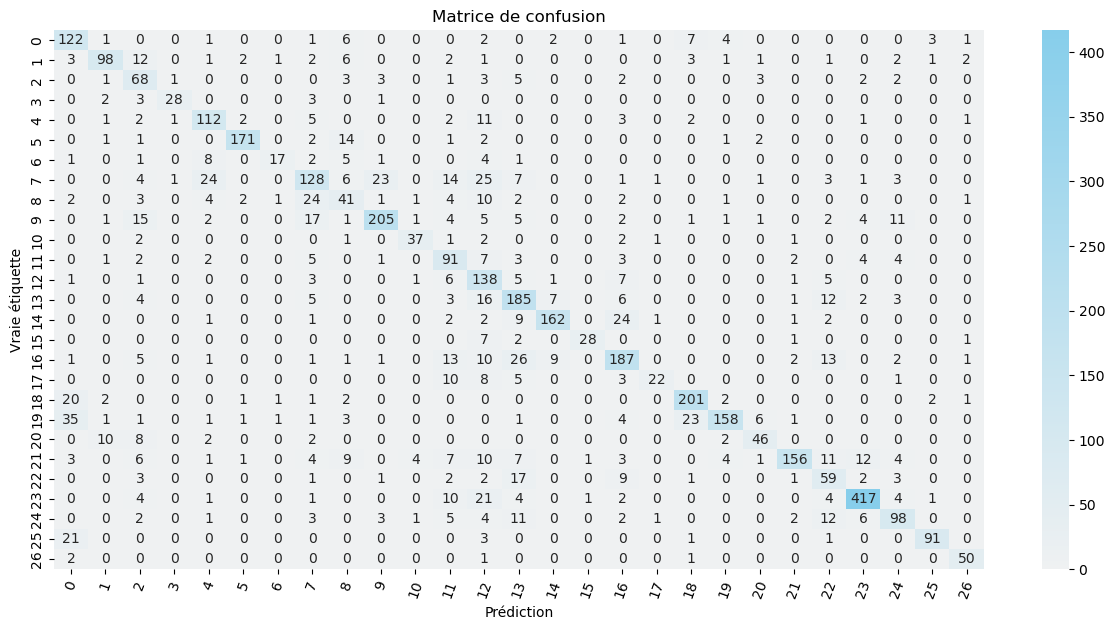

In [65]:
ima_cf = confusion_matrix(y_pred['index'], y_ima_pred)
plt.figure(figsize=(15, 7))
palette_bleu=sns.light_palette("#87CEEB", as_cmap=True)
sns.heatmap(ima_cf, annot=True,  cmap=palette_bleu, fmt = 'd')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.xticks(rotation=70)
plt.ylabel('Vraie étiquette')
plt.show()

In [66]:
print(classification_report(y_pred['index'], y_ima_pred))

              precision    recall  f1-score   support

           0       0.58      0.81      0.67       151
           1       0.82      0.71      0.76       139
           2       0.46      0.72      0.56        94
           3       0.90      0.76      0.82        37
           4       0.69      0.78      0.73       143
           5       0.95      0.88      0.91       195
           6       0.81      0.42      0.56        40
           7       0.60      0.53      0.56       242
           8       0.42      0.41      0.42        99
           9       0.85      0.74      0.79       278
          10       0.82      0.79      0.80        47
          11       0.51      0.73      0.60       125
          12       0.47      0.82      0.60       169
          13       0.63      0.76      0.69       244
          14       0.90      0.79      0.84       205
          15       0.93      0.72      0.81        39
          16       0.71      0.68      0.70       273
          17       0.85    

## Prédictions pour les images + le texte

In [27]:
image_size = 299 # Modèle Xception
batch_size = 32
prefetch_factor = tf.data.experimental.AUTOTUNE 
path =  "../data/images/image_train/"

In [28]:
# fonction pour le chargement des images sans augmentation
def load_image(filepath) :
    # Chargement de l'image du df en mémoire
    im = tf.io.read_file(filepath)
    
    # Décodage de l'info dans un tenseur RGB
    im = tf.image.decode_jpeg(im, 3)
    
    # Retourne l'image à la bonne dimension 
    im = tf.image.resize(im, size=(image_size, image_size))
    
    # Preprocess du modèle
    im = tf.keras.applications.xception.preprocess_input(im)
        
    return im

In [29]:
y_pred['index']

36138    26
68630     8
36172    16
9830      7
28422    18
         ..
32607     8
69875    16
1285      2
50914     5
81243    17
Name: index, Length: 4246, dtype: int64

In [30]:
# Création du dataset
# Partie texte
X_pred_text = np.asarray([np.asarray(x) for x in X_pred['tokens']])
X_pred_text  = tf.concat(X_pred_text , axis = 0)
X_pred_path = [path + X_pred['path'].iloc[k] for k in range(len(X_pred))]

# Partie image #
# définition de dataset_pred
dataset_pred = tf.data.Dataset.from_tensor_slices((X_pred_text, X_pred_path, y_pred['index']))

# application de la fonction load_image au dataset
dataset_pred = dataset_pred.map(lambda x, y, z : [(x,load_image(y)),z], num_parallel_calls = -1).cache()

# regroupement en batchs
dataset_pred = dataset_pred.batch(batch_size).prefetch(prefetch_factor)

In [31]:
# chargement du best modèle texte+image
model_tex_ima = load( "../models/xception_unfreeze105_Embedding100_4ep_full_data.joblib")

In [32]:
score = model_tex_ima.evaluate(dataset_pred)

print("Accuracy - Modèle Embedding + Xception / Full Data:",score[1])

133/133 [==============================] - 551s 4s/step - loss: 0.3296 - accuracy: 0.9192
Accuracy - Modèle Embedding + Xception / Full Data: 0.9192180633544922


In [33]:
y_tex_ima_proba = model_tex_ima.predict(dataset_pred, verbose = 1)

133/133 [==============================] - 541s 4s/step


In [34]:
y_tex_ima_pred = np.argmax(y_tex_ima_proba  , axis =-1)

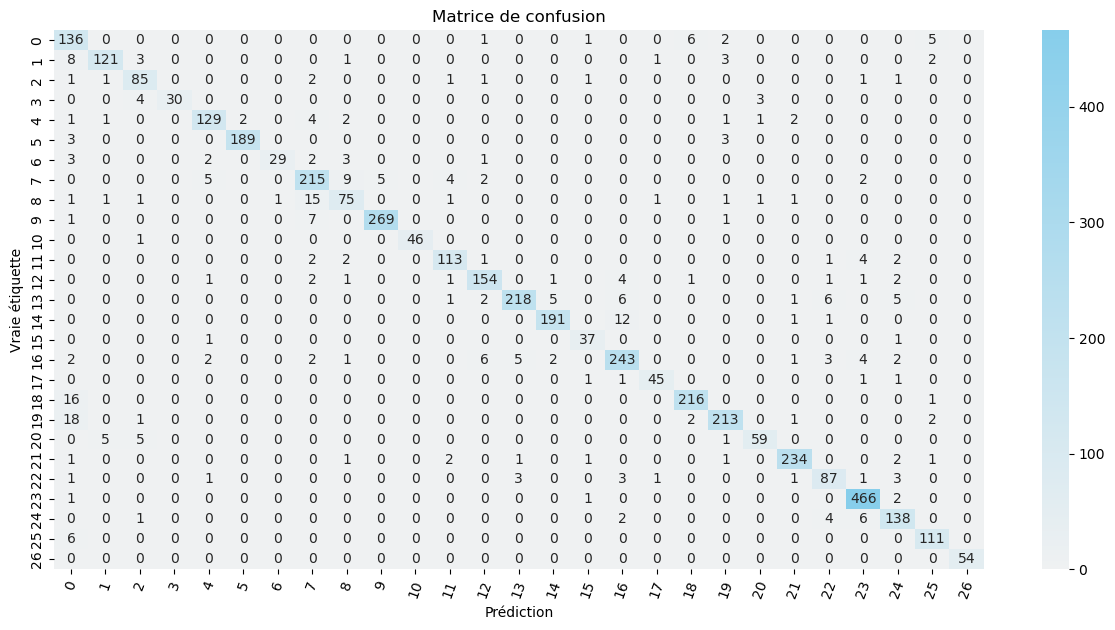

In [35]:
tex_ima_cf = confusion_matrix(y_pred['index'], y_tex_ima_pred)
plt.figure(figsize=(15, 7))
palette_bleu=sns.light_palette("#87CEEB", as_cmap=True)
sns.heatmap(tex_ima_cf, annot=True,  cmap=palette_bleu, fmt = 'd')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.xticks(rotation=70)
plt.ylabel('Vraie étiquette')
plt.show()

In [36]:
print(classification_report(y_pred['index'], y_tex_ima_pred))

              precision    recall  f1-score   support

           0       0.68      0.90      0.78       151
           1       0.94      0.87      0.90       139
           2       0.84      0.90      0.87        94
           3       1.00      0.81      0.90        37
           4       0.91      0.90      0.91       143
           5       0.99      0.97      0.98       195
           6       0.97      0.72      0.83        40
           7       0.86      0.89      0.87       242
           8       0.79      0.76      0.77        99
           9       0.98      0.97      0.97       278
          10       1.00      0.98      0.99        47
          11       0.92      0.90      0.91       125
          12       0.92      0.91      0.91       169
          13       0.96      0.89      0.93       244
          14       0.96      0.93      0.95       205
          15       0.88      0.95      0.91        39
          16       0.90      0.89      0.89       273
          17       0.94    

## Sauvegarde des prévisions dans un dataframe

In [70]:
rakuten_predictions = y_pred

In [71]:
rakuten_predictions.head()

,prdtypecode,index
36138,2905,26
68630,1281,8
36172,2060,16
9830,1280,7
28422,2280,18


In [75]:
X_pred.head()

,level_0,designation,path,tokens,index,str_index
0,36138,Nk Pro Racing - Jeu En Téléchargement,image_1100082580_product_1711734527.jpg,"[75, 1328, 366, 929, 0, 0, 0, 0, 0, 0, 0, 0, 0...",26,26
1,68630,Exit - Tombeau Du Pharaon,image_1139624392_product_2397542298.jpg,"[8568, 25083, 18136, 0, 0, 0, 0, 0, 0, 0, 0, 0...",8,8
2,36172,Bricolage Lettres En Mousse D'argent Alphabet ...,image_1271697301_product_3979577549.jpg,"[1090, 986, 2556, 1622, 602, 403, 1625, 1990, ...",16,16
3,9830,Nostalgique Fer Blanc Clockwork Chaîne Jouet P...,image_1313204688_product_4197657726.jpg,"[1583, 3987, 71, 7214, 1648, 386, 2745, 2747, ...",7,7
4,28422,Le Courrier De L'unesco Mai 1996 N° 9605 : Le...,image_518749844_product_52594358.jpg,"[7279, 7549, 3349, 6196, 0, 0, 0, 0, 0, 0, 0, ...",18,18


In [73]:
rakuten_predictions = rakuten_predictions.reset_index()

In [74]:
rakuten_predictions =  rakuten_predictions.drop(['level_0' ],axis = 1)
rakuten_predictions.head()

,prdtypecode,index
0,2905,26
1,1281,8
2,2060,16
3,1280,7
4,2280,18


In [76]:
rakuten_predictions['designation'] = X_pred['designation']
rakuten_predictions['path'] = X_pred['path']
rakuten_predictions['y_tex'] = pd.Series(y_text_pred).astype('int64')
rakuten_predictions['y_ima'] =  pd.Series(y_ima_pred).astype('int64')
rakuten_predictions['y_tex_ima'] =  pd.Series(y_tex_ima_pred).astype('int64')

In [77]:
rakuten_predictions.head()

,prdtypecode,index,designation,path,y_tex,y_ima,y_tex_ima
0,2905,26,Nk Pro Racing - Jeu En Téléchargement,image_1100082580_product_1711734527.jpg,26,26,26
1,1281,8,Exit - Tombeau Du Pharaon,image_1139624392_product_2397542298.jpg,5,5,8
2,2060,16,Bricolage Lettres En Mousse D'argent Alphabet ...,image_1271697301_product_3979577549.jpg,16,16,16
3,1280,7,Nostalgique Fer Blanc Clockwork Chaîne Jouet P...,image_1313204688_product_4197657726.jpg,7,7,7
4,2280,18,Le Courrier De L'unesco Mai 1996 N° 9605 : Le...,image_518749844_product_52594358.jpg,18,18,18


In [78]:
rakuten_predictions.to_csv("../data/rakuten_predictions_3modeles_4246articles_full_data.csv", index=False)